<a href="https://colab.research.google.com/github/FotoVoltz/PV_Systems/blob/main/Project_Spectrum_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Comparative Analysis of Multijunction Photovoltaic Technologies for Terrestrial and Space Applications

Python code to interpolate and multiply PCE and irradiance spectra in order to calculate current output of different solar cell technologies.

## Set up

Installing relevant python libraries

In [ ]:
!pip install pandas>1.0 matplotlib

Importing relevant modules

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
plt.rcParams['figure.dpi'] = 150

## Methodology

This code loads a spectrum and a sparsely sampled EQE spectrum from a public GitHub repository and interpolates both spectra to a 1nm resolution.

With these two interpolated spectra it should be easy enough to convert the spectrums AM1.5G and AM0  to a photon flux and multiple by the EQE spectrum before summing to get a short circuit current density. By loading different EQE spectra from different solar cells a comparison can be made.

### Loading spectrum data

A function to handle non-integer wavelengths in our sample data by rounding:

In [ ]:
def clean_up_wavelengths(input_spectrum):
    """Make allowances for non-integer wavelengths and possible duplicate wavelengths"""
    ## Reset the index so "Wavelength (nm)" is a column
    input_spectrum.reset_index(inplace=True)
    ## Round the "Wavelength (nm)" column to 0 decimal places
    input_spectrum["Wavelength (nm)"] = input_spectrum["Wavelength (nm)"].round(0)
    ## Remove any duplicate values from the "Wavelength (nm)" column
    input_spectrum.drop_duplicates(subset="Wavelength (nm)", keep="first", inplace=True)
    ## Set the Dataframe index back to the "Wavelength (nm)" column
    input_spectrum.set_index("Wavelength (nm)", inplace=True)
    return input_spectrum

Loading the AM1.5G/AM0 and EQE spectra from GitHub into Dataframes:

In [ ]:
am15_url = "https://raw.githubusercontent.com/FotoVoltz/PV_Systems/main/AM1_5G.csv"
#am0_url = https://raw.githubusercontent.com/FotoVoltz/PV_Systems/main/AM0.csv

eqe_url = "https://raw.githubusercontent.com/FotoVoltz/PV_Systems/main/Top%20Cell%20PVK.csv"
#Other EQE data can be found here: https://github.com/FotoVoltz/PV_Systems

#AM1.5G and AM0 Data References: https://www.pveducation.org/sites/default/files/PVCDROM/Appendices/AM0AM1_5.xls
#EQE Data References: https://doi.org/10.1021/acs.jpclett.6b00002, https://doi.org/10.1038/s41586-023-06006-7, https://doi.org/10.1109/PVSC.2010.5614525

def load_am15_spectrum(url):
    """Load an AM1.5 spectrum dataset from a URL."""
    am15_spectrum = pd.read_csv(url, header=0, names=["Wavelength (nm)", "Power (W/m2/nm)"],
                                index_col="Wavelength (nm)", dtype=np.float64)
    # Allow for non-integer wavelengths and possible dupe values in our sample data
    am15_spectrum = clean_up_wavelengths(am15_spectrum)
    return am15_spectrum

def load_eqe_spectrum(url):
    """Load an EQE spectrum dataset from a URL."""
    eqe_spectrum = pd.read_csv(url, header=0, names=["Wavelength (nm)", "EQE (%)"],
                               index_col="Wavelength (nm)", dtype=np.float64)
    # Allow for non-integer wavelengths and possible duplicate values in our sample data
    eqe_spectrum = clean_up_wavelengths(eqe_spectrum)
    return eqe_spectrum

am15_spectrum = load_am15_spectrum(am15_url)
eqe_spectrum = load_eqe_spectrum(eqe_url)

Defining the start and end wavelengths that the interpolation function should operate over. This should be inside the range of both sets of data to avoid extrapolation. Some manual padding of the EQE data might be needed.

In [ ]:
start_wl = 300
end_wl = 2000
step_wl = 1

# Make sure we haven't set a start and end wavelength outside the range of the input spectra
min_wl = max(am15_spectrum.index.min(), eqe_spectrum.index.min())
max_wl = min(am15_spectrum.index.max(), eqe_spectrum.index.max())
start_wl = max(min_wl, start_wl)
end_wl = min(max_wl, end_wl)

### Creating an interpolation function

Takes a spectrum Dataframe (`input_spectrum`) with `Wavelength (nm)` as it's index and one column or more columns to be interpolated between `start_wl` and `end_wl` with fixed `step_wl` intervals. A cubic spline is chosen for the interpolation.

In [ ]:
def interpolate_wl_spectrum(start_wl, end_wl, step_wl, input_spectrum):
    """Use cubic spline interpolation to fill in any gaps in our spectrum."""
    desired_index = pd.RangeIndex(start=start_wl, stop=end_wl, step=step_wl, name="Wavelength (nm)").astype(np.float64)
    padded = input_spectrum.reindex(desired_index)
    interpolated = padded.interpolate(method="cubic")
    return interpolated

Interpolating the AM1.5 spectrum and plotting it:

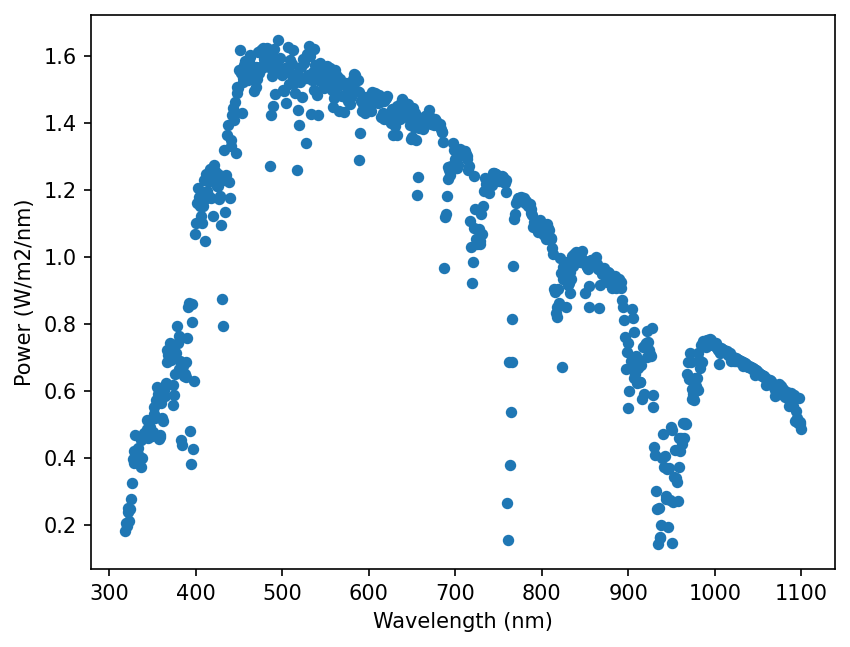

In [ ]:
am15_interpolated = interpolate_wl_spectrum(start_wl=start_wl, end_wl=end_wl, step_wl=step_wl,
                                            input_spectrum=am15_spectrum)
am15_interpolated.reset_index().plot(x="Wavelength (nm)", y="Power (W/m2/nm)", kind="scatter");

Interpolating the EQE spectrum and plotting it:

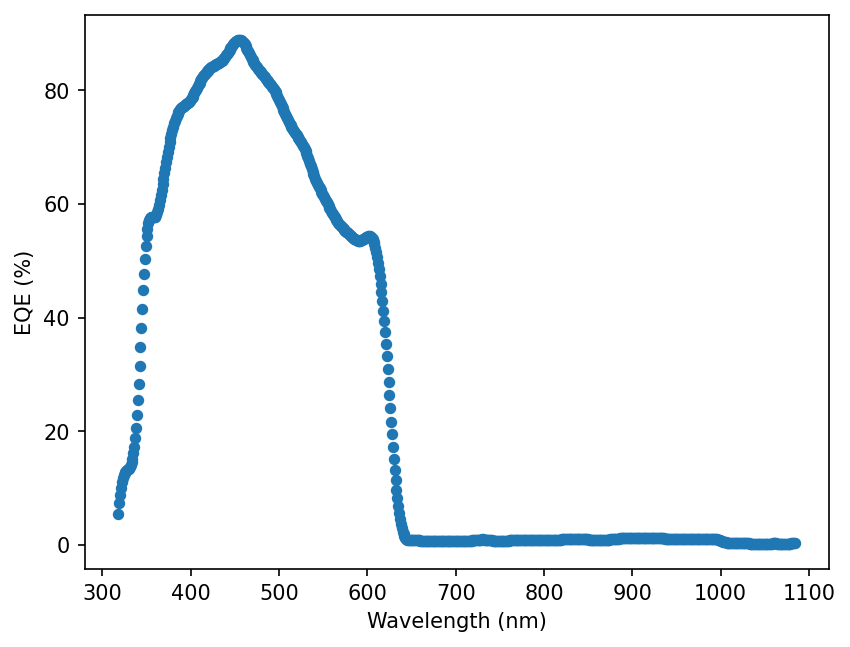

In [ ]:
eqe_interpolated = interpolate_wl_spectrum(start_wl=start_wl, end_wl=end_wl, step_wl=step_wl,
                                           input_spectrum=eqe_spectrum)
eqe_interpolated.reset_index().plot(x="Wavelength (nm)", y="EQE (%)", kind="scatter");

## Next steps

Creating a photon flux column either in the same data frame, and multiplying the EQE spectrum and the AM1.5 photon flux together to create an electron flux spectrum. Further, multiplying by the charge on an electron, to convert this to an integrated current density. Finally, saving the data frame into my Google Drive as CSV file.

In [ ]:
# When merging two dataframes, using the "inner" join tell Pandas to keep only the matching rows from both dataframes
# This line merges the dataframes associated with EQE and AM1.5
combined = am15_interpolated.merge(eqe_interpolated, left_index=True, right_index=True, how="inner").reset_index()

# Next is to calculate the photon flux as a new column in the "combined" dataframe
combined["Flux (/m2/nm)"] = combined["Power (W/m2/nm)"] * combined["Wavelength (nm)"] * (10**-9) / (6.63*10**-34*3*10**8)
combined["EQE"] = combined["EQE (%)"]/100

# and then you can also calculate the "current spectrum" - the current per nm per m2.
combined["Current Spectrum (A/m2/nm)"] = (1.6*10**-19) * combined["Flux (/m2/nm)"] * combined["EQE"]

# finally to show the dataframe "combined"
combined

combined.to_csv('TopPVK_AM1_5G.csv')
!cp 'TopPVK_AM1_5G.csv' "drive/My Drive/Colab Data/"

In [ ]:
# the total Jsc is the sum of all the current in the current spectrum.  you can use the .sum() function on the "combined" dataframe
jsc = combined["Current Spectrum (A/m2/nm)"].sum()
print(f"JSc is: {jsc:.3f} A/m2")

JSc is: 104.033 A/m2


In [ ]:
# this is a slightly more sophisticated approach where only values above zero are included. negative values occur becuase of the interpolation.
jsc = combined.loc[combined["Current Spectrum (A/m2/nm)"] >= 0, "Current Spectrum (A/m2/nm)"].sum()
print(f"JSc is: {jsc:.3f} A/m2")

JSc is: 104.033 A/m2


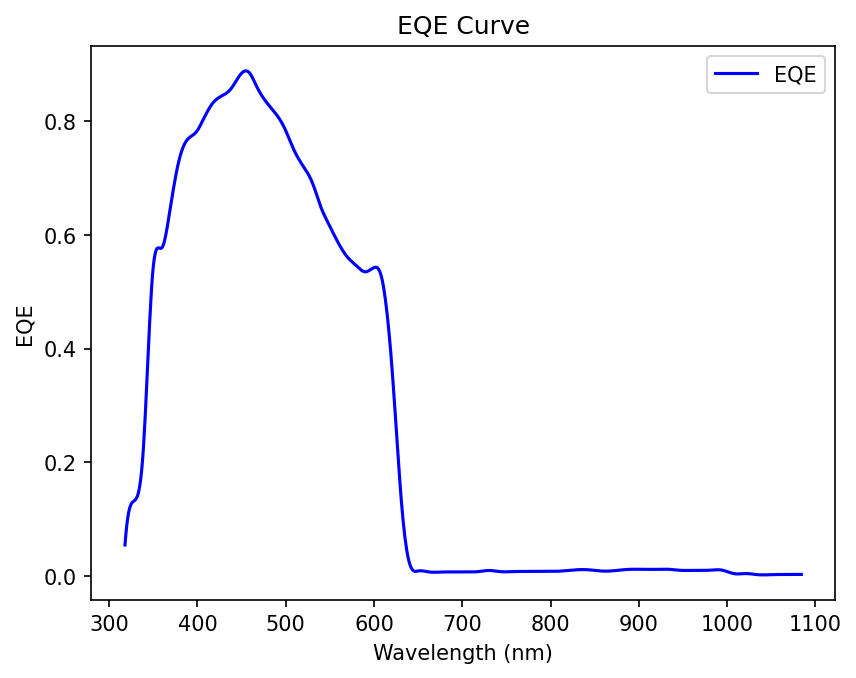

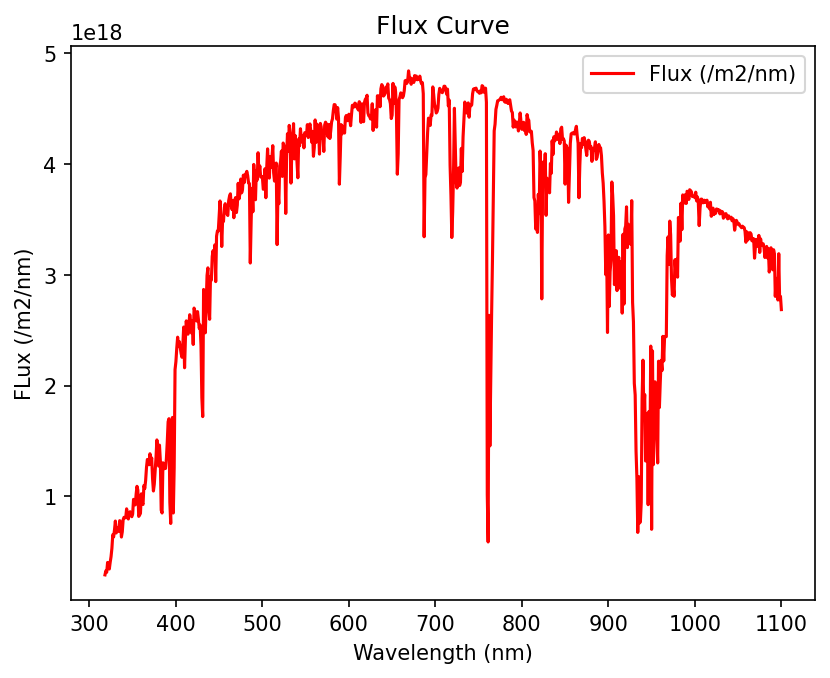

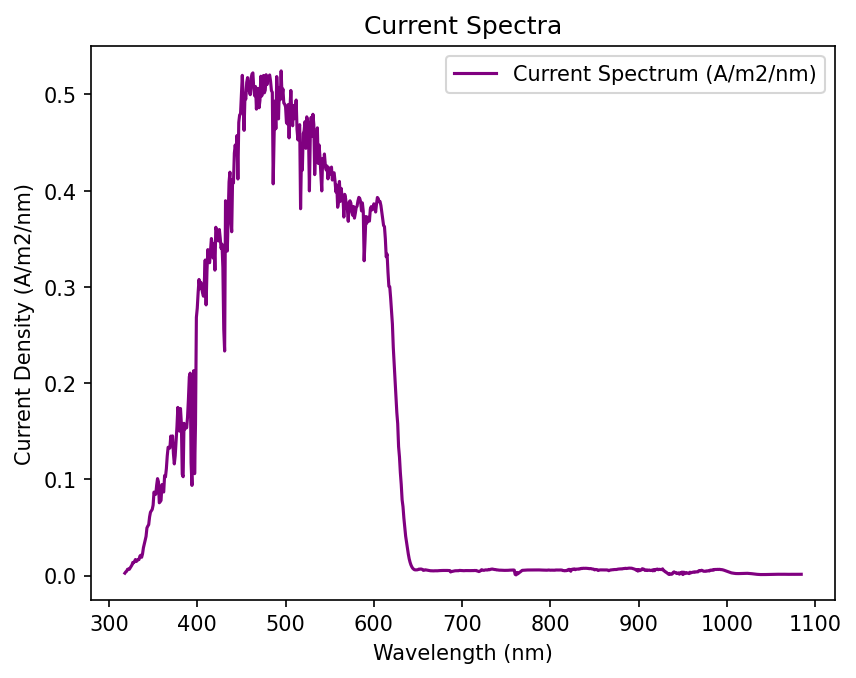

In [ ]:
# Plotting the relevant data
combined.plot(x="Wavelength (nm)", y="EQE", title="EQE Curve", xlabel="Wavelength (nm)", ylabel="EQE", color='blue');
combined.plot(x="Wavelength (nm)", y="Flux (/m2/nm)", title="Flux Curve", xlabel="Wavelength (nm)", ylabel="FLux (/m2/nm)", color='red');
combined.plot(x="Wavelength (nm)", y="Current Spectrum (A/m2/nm)", title="Current Spectra", xlabel="Wavelength (nm)", ylabel="Current Density (A/m2/nm)", color='purple');

This Python Code was originally developed by Prof. Alastair Buckley and Jamie Taylor. This particular code written above is an extension of their code.
